In [4]:
import os
import tarfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from pathlib import Path

warnings.filterwarnings("ignore")

Extracting the data from the .tgz format

In [5]:
def extract(tar_url, extract_path='training_data/'):
    print(tar_url)
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])


extract('flood-train-images' + '.tgz')
extract('flood-train-labels' + '.tgz')
print ('Done.')

Let's specify where our images extracted from the tar file and metadata live locally.

In [6]:
DATA_PATH = Path("training_data")
ORIGINAL_DATA_PATH = Path("original_training_data")

FEATURE_PATH = ORIGINAL_DATA_PATH / "train_features"
LABEL_PATH = DATA_PATH / "train_labels"

train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [5]:
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

The training data include chips from 13 flood events. We have anywhere from 15 to 69 chips (30 to 138 images) per unique event, with half of events containing fewer than 32 chips (64 images).

Text(0.5, 1.0, 'Number of Images by Location')

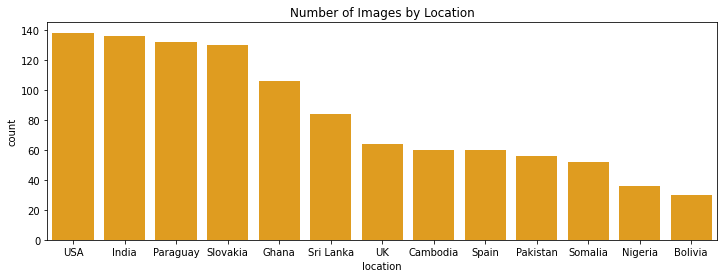

In [6]:
plt.figure(figsize=(12, 4))
sns.countplot(
    x=train_metadata.location,
    order=train_metadata.location.value_counts().index,
    color="orange",
)
plt.title("Number of Images by Location")

In [7]:
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year)["flood_id"].nunique()
year_counts

scene_start
2016    1
2017    2
2018    6
2019    3
2020    1
Name: flood_id, dtype: int64

The training data cover flood events that occurred between 2016 and 2020. Images for each event were captured on the same day.

A GeoTIFF is a raster image file that contains geographic metadata describing the location of the image. This metadata can include bounding coordinates, an affine transform, and a coordinate reference system (CRS) projection. The package rasterio makes it easy to interact with our geospatial raster data.


Each set of two polarizations (vh and vh) correspond with a **single** water label.

In [8]:
# Examine an arbitrary image
image_path = FEATURE_PATH / f"{train_metadata.image_id[0]}.tif"

with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  # read a single band

metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32720),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

Checking for non valid/missing data and resolving them for the analysis

In [9]:
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()

gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

Pixel values represent energy that was reflected back to the satellite measured in decibels. To better visualize the bands or channels of Sentinel-1 images, we will create a false color composite by treating the two bands and their ratio as red, grean, and blue channels, respectively. We will prepare a few helper functions to visualize the data.

In [10]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]

    # Extract paths to image files
    vv_path = FEATURE_PATH / f"{random_chip}_vv.tif"
    vh_path = FEATURE_PATH / f"{random_chip}_vh.tif"
    label_path = LABEL_PATH / f"{random_chip}.tif"

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)
    
    plt.tight_layout(pad=5)
    plt.show()

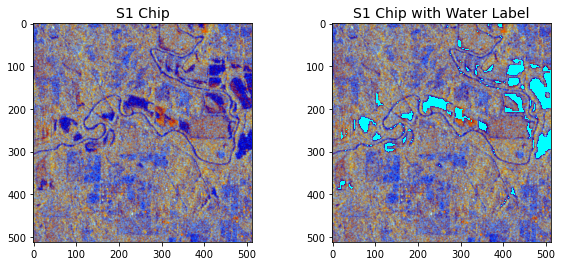

In [11]:
display_random_chip(22)

## Supplementary data from Nasadem and JRC (Global Surface Water)

In [12]:
from dataclasses import dataclass
from tempfile import TemporaryDirectory
from typing import List, Any, Dict

import planetary_computer as pc
import pyproj
import rasterio
from osgeo import gdal
from pystac_client import Client
from rasterio.warp import reproject, Resampling
from shapely.geometry import box, mapping

In [13]:
TRAINING_DATA_DIR = os.path.join(os.getcwd(), 'training_data/train_features')

In [14]:
chip_paths = []
for file_name in os.listdir(TRAINING_DATA_DIR):
    if file_name.endswith("_vv.tif"):
        chip_paths.append(os.path.join(TRAINING_DATA_DIR, file_name))
print(f"{len(chip_paths)} chips found.")

542 chips found.


In [15]:
#Creating STAC API client
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(STAC_API)

In [16]:
@dataclass
class ChipInfo:
    """
    Holds information about a training chip, including geospatial info for coregistration
    """

    path: str
    prefix: str
    crs: Any
    shape: List[int]
    transform: List[float]
    bounds: rasterio.coords.BoundingBox
    footprint: Dict[str, Any]


def get_footprint(bounds, crs):
    """Gets a GeoJSON footprint (in epsg:4326) from rasterio bounds and CRS"""
    transformer = pyproj.Transformer.from_crs(crs, "epsg:4326", always_xy=True)
    minx, miny = transformer.transform(bounds.left, bounds.bottom)
    maxx, maxy = transformer.transform(bounds.right, bounds.top)
    return mapping(box(minx, miny, maxx, maxy))


def get_chip_info(chip_path):
    """Gets chip info from a GeoTIFF file"""
    with rasterio.open(chip_path) as ds:
        chip_crs = ds.crs
        chip_shape = ds.shape
        chip_transform = ds.transform
        chip_bounds = ds.bounds

    # Use the first part of the chip filename as a prefix
    prefix = os.path.basename(chip_path).split("_")[0]

    return ChipInfo(
        path=chip_path,
        prefix=prefix,
        crs=chip_crs,
        shape=chip_shape,
        transform=chip_transform,
        bounds=chip_bounds,
        footprint=get_footprint(chip_bounds, chip_crs),
    )

_Reprojection_ is the process of transforming a raster from one coordinate system to another coordinate system. This allows data sources in different coordinate systems be used together.

In [17]:
def reproject_to_chip(
    chip_info, input_path, output_path, resampling=Resampling.nearest
):
    """
    Reproject a raster at input_path to chip_info, saving to output_path.

    Use Resampling.nearest for classification rasters. Otherwise use something
    like Resampling.bilinear for continuous data.
    """
    with rasterio.open(input_path) as src:
        kwargs = src.meta.copy()
        kwargs.update(
            {
                "crs": chip_info.crs,
                "transform": chip_info.transform,
                "width": chip_info.shape[1],
                "height": chip_info.shape[0],
                "driver": "GTiff",
            }
        )

        with rasterio.open(output_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=chip_info.transform,
                    dst_crs=chip_info.crs,
                    resampling=Resampling.nearest,
                )

In [18]:
def write_vrt(items, asset_key, dest_path):
    """Write a VRT with hrefs extracted from a list of items for a specific asset."""
    hrefs = [pc.sign(item.assets[asset_key].href) for item in items]
    vsi_hrefs = [f"/vsicurl/{href}" for href in hrefs]
    gdal.BuildVRT(dest_path, vsi_hrefs).FlushCache()

In [19]:
def create_chip_aux_file(
    chip_info, collection_id, asset_key, file_name, resampling=Resampling.nearest
):
    """
    Write an auxiliary chip file.

    The auxiliary chip file includes chip_info for the Collection and Asset, and is
    saved in the same directory as the original chip with the given file_name.
    """
    output_path = os.path.join(
        os.path.dirname(chip_info.path), f"{chip_info.prefix}_{file_name}"
    )
    search = catalog.search(collections=[collection_id], intersects=chip_info.footprint)
    items = list(search.get_items())
    with TemporaryDirectory() as tmp_dir:
        vrt_path = os.path.join(tmp_dir, "source.vrt")
        write_vrt(items, asset_key, vrt_path)
        reproject_to_chip(chip_info, vrt_path, output_path, resampling=resampling)
    return output_path

Configurate the auxiliary input files that we will generate.

In [20]:
# Define a set of parameters to pass into create_chip_aux_file
aux_file_params = [
    ("nasadem", "elevation", "nasadem.tif", Resampling.bilinear),
    ("jrc-gsw", "extent", "jrc-gsw-extent.tif", Resampling.nearest),
    ("jrc-gsw", "occurrence", "jrc-gsw-occurrence.tif", Resampling.nearest),
    ("jrc-gsw", "recurrence", "jrc-gsw-recurrence.tif", Resampling.nearest),
    ("jrc-gsw", "seasonality", "jrc-gsw-seasonality.tif", Resampling.nearest),
    ("jrc-gsw", "transitions", "jrc-gsw-transitions.tif", Resampling.nearest),
    ("jrc-gsw", "change", "jrc-gsw-change.tif", Resampling.nearest),
]

Generate auxiliary input chips for NASADEM and JRC

In [21]:
# Iterate over the chips and generate all aux input files.
count = len(chip_paths)
for i, chip_path in enumerate(chip_paths):
    print(f"({i+1} of {count}) {chip_path}")
    chip_info = get_chip_info(chip_path)
    for collection_id, asset_key, file_name, resampling_method in aux_file_params:
        print(f"  ... Creating chip data for {collection_id} {asset_key}")
        create_chip_aux_file(
            chip_info, collection_id, asset_key, file_name, resampling=resampling_method
        )

In [22]:
#check directory with new data
print('Tot number of initial training data: ', len(train_metadata))
print('Tot number of new integrated training data: ', len(os.listdir(TRAINING_DATA_DIR)))
print('-------------------------------------------------')
print('Added', len(os.listdir(TRAINING_DATA_DIR))-len(train_metadata), 'images')

Tot number of initial training data:  1084
Tot number of new integrated training data:  4878
-------------------------------------------------
Added 3794 images


**Visualisations**:

In [23]:
train_features = Path.cwd().parent / 'thesis'/"training_data" / "train_features"
train_labels = Path.cwd().parent / 'thesis'/"training_data" / "train_labels"

In [24]:
hxu12_vv = gdal.Open(str(train_features / "hbe54_vv.tif")).ReadAsArray()
hxu12_nasadem = gdal.Open(str(train_features / "hbe54_jrc-gsw-change.tif")).ReadAsArray()
hxu12_mask = gdal.Open(str(train_labels / "hbe54.tif")).ReadAsArray()

l = [hxu12_vv, hxu12_nasadem, hxu12_mask]

In [25]:
def showImagesHorizontally(list_of_files):
    plt.rcParams["figure.figsize"] = [10, 10]
    fig, ax = plt.subplots(1,3)
    for i in range(len(list_of_files)):
        plt.subplot(1, 3, i+1)
        plt.imshow(list_of_files[i])

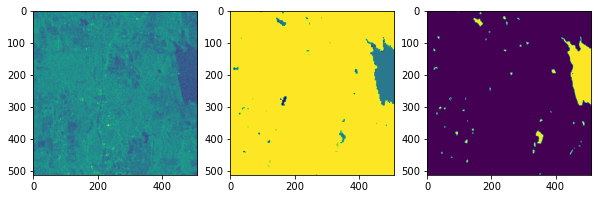

In [26]:
showImagesHorizontally(l)